# sync intern 

**task 4: sign language classification**

**vivek popat shedge**


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image 
%matplotlib inline
from sklearn.metrics import confusion_matrix,plot_confusion_matrix, plot_roc_curve
from sklearn.metrics import classification_report
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_dir = "C:/msc-II/asl_dataset"

data = tf.keras.preprocessing.image_dataset_from_directory(data_dir)

Found 5030 files belonging to 37 classes.


In [4]:
from tensorflow.keras import backend as K

def precision(y_true, y_pred):  
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1(y_true, y_pred):
    precision_f = precision(y_true, y_pred)
    recall_f = recall(y_true, y_pred)
    return 2*((precision_f*recall_f)/(precision_f+recall_f+K.epsilon()))

In [5]:
import os
num_skipped = 0
for folder_name in ("0","1","2","3","4","5","6","7","8","9","a","b","c","d","e","f","g","h","i","j","k","l","m","n","o"
                    ,"p","q","r","s","t","u","v","w","x","y","z"):
    folder_path = os.path.join(data_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()
        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
print("Deleted %d images" % num_skipped)

Deleted 0 images


In [6]:
datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 40,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        fill_mode = 'nearest',
        validation_split = 0.2)

In [7]:
height = 299
width = 299
channels = 3
batch_size = 32
img_shape = (height, width, channels)
img_size = (height, width)

In [8]:
train_data = datagen.flow_from_directory(
    data_dir,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training',
    target_size = img_size
)

val_data = datagen.flow_from_directory(
    data_dir,
    batch_size = batch_size,
    class_mode='categorical',
    subset = 'validation',
    target_size = img_size
)

Found 4024 images belonging to 37 classes.
Found 1006 images belonging to 37 classes.


In [9]:
num_classes = len(data.class_names)
print('.... Number of Classes : {0} ....'.format(num_classes))

.... Number of Classes : 37 ....


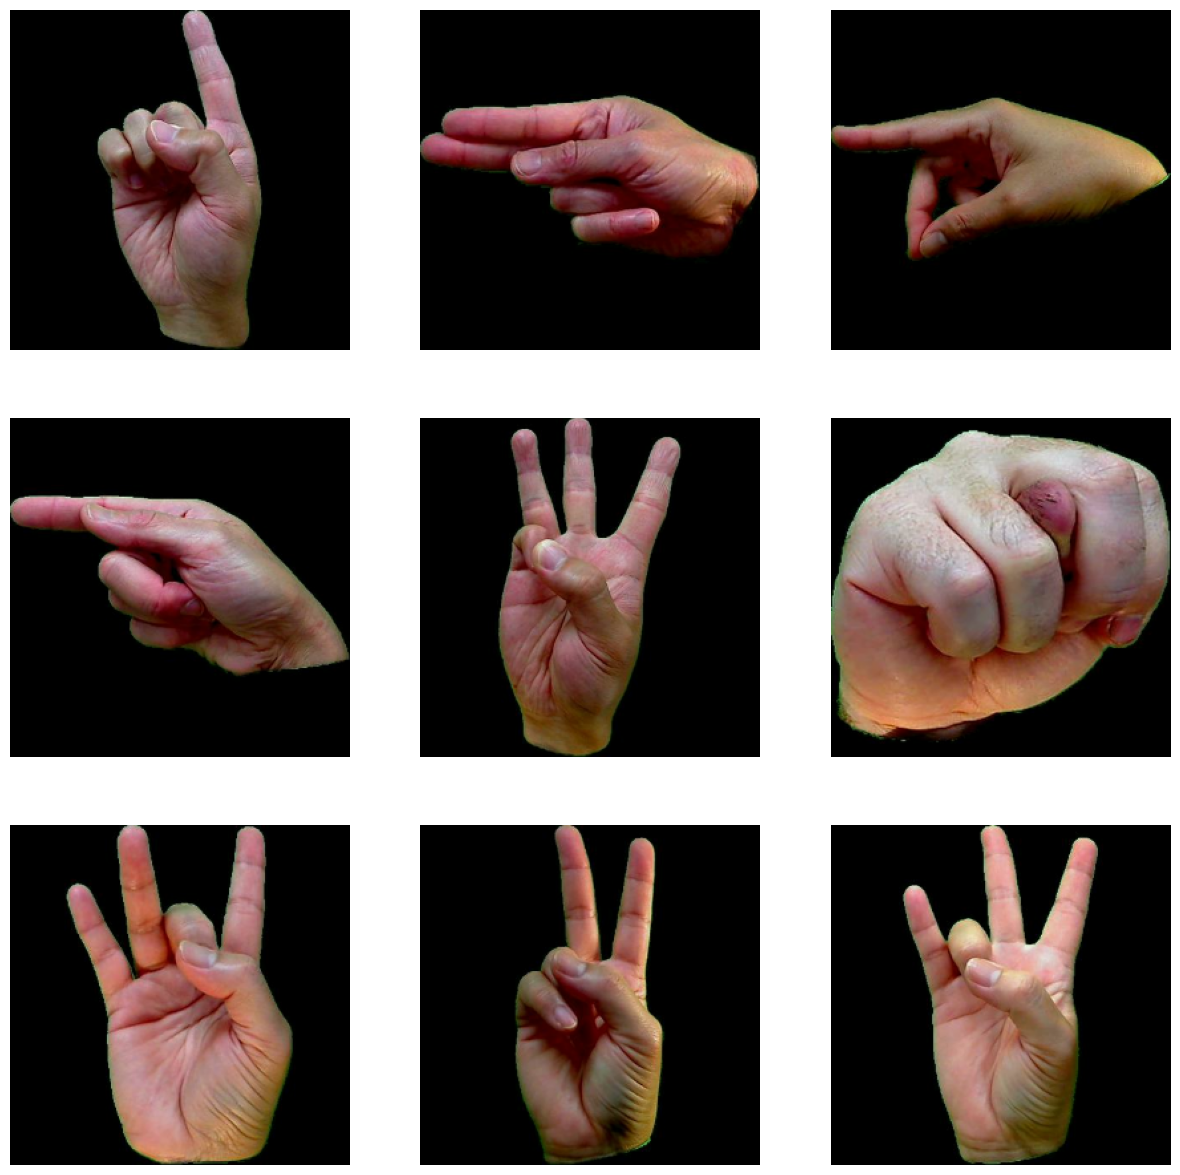

In [10]:
def show_img(data):
    plt.figure(figsize=(15,15))
    for images, labels in data.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("off")

#Plotting the images in dataset
show_img(data)

In [11]:
pre_trained = InceptionV3(weights='imagenet', include_top=False, input_shape=img_shape, pooling='max')

for layer in pre_trained.layers:
    layer.trainable = False

In [12]:
x = pre_trained.output
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs = pre_trained.input, outputs = predictions)
model.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [14]:
STEP_SIZE_TRAIN = train_data.n // train_data.batch_size
STEP_SIZE_VALID = val_data.n // val_data.batch_size

history = model.fit_generator(train_data,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = val_data,
                    validation_steps = STEP_SIZE_VALID,
                    epochs = 20,
                    verbose = 1)

Epoch 1/20
125/125 [==============================] - 339s 3s/step - loss: 2.7996 - accuracy: 0.4013 - val_loss: 3.4906 - val_accuracy: 0.3659
Epoch 2/20
125/125 [==============================] - 349s 3s/step - loss: 2.2624 - accuracy: 0.4451 - val_loss: 3.3387 - val_accuracy: 0.3095
Epoch 3/20
125/125 [==============================] - 358s 3s/step - loss: 1.9526 - accuracy: 0.4679 - val_loss: 3.2615 - val_accuracy: 0.3004
Epoch 4/20
125/125 [==============================] - 339s 3s/step - loss: 1.8221 - accuracy: 0.4792 - val_loss: 3.0858 - val_accuracy: 0.2581
Epoch 5/20
125/125 [==============================] - 336s 3s/step - loss: 1.6549 - accuracy: 0.4775 - val_loss: 3.7053 - val_accuracy: 0.2369
Epoch 6/20
125/125 [==============================] - 327s 3s/step - loss: 1.5086 - accuracy: 0.4975 - val_loss: 3.1925 - val_accuracy: 0.2440
Epoch 7/20
125/125 [==============================] - 335s 3s/step - loss: 1.3625 - accuracy: 0.5095 - val_loss: 3.0934 - val_accuracy: 0.2540

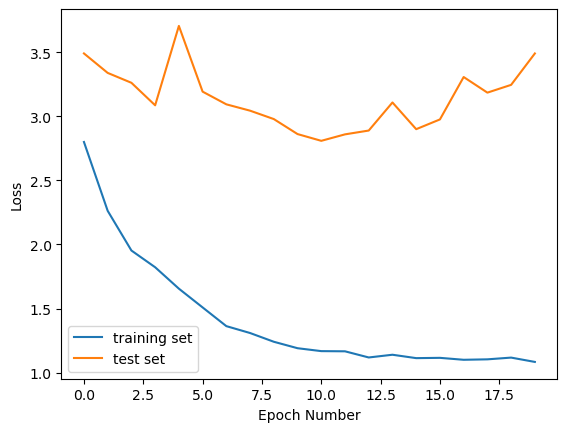

In [21]:
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='training set')
plt.plot(history.history['val_loss'], label='test set')
plt.legend()

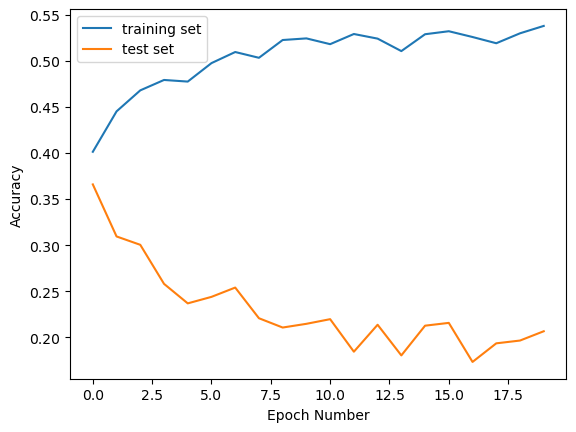

In [16]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='training set')
plt.plot(history.history['val_accuracy'], label='test set')
plt.legend()

In [17]:
model_name = 'Sign_InceptionV3.h5'
model.save(model_name, save_format='h5')

In [18]:
class_map = train_data.class_indices
classes = []
for key in class_map.keys():
    classes.append(key)

In [19]:
def predict_image(filename, model):
    img_ = image.load_img(filename, target_size=(299, 299))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0)
    img_processed /= 255.
    
    prediction = model.predict(img_processed)
    
    index = np.argmax(prediction)
    
    plt.title("Prediction - {}".format(str(classes[index]).title()), size=18, color='red')
    plt.imshow(img_array)

1/1 [==============================] - 1s 1s/step


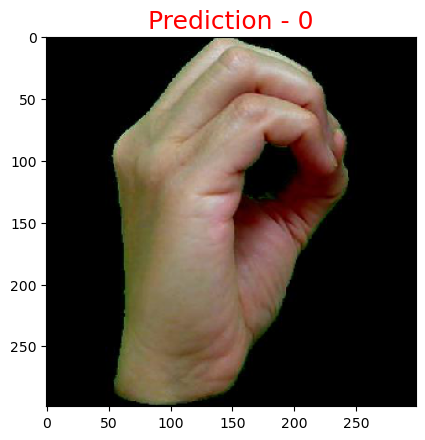

In [20]:
predict_image('C:/msc-II/asl_dataset/0/hand2_0_dif_seg_2_cropped.jpeg', model)
